# Sentiment Analysis on News arcticles for Cryptocurrencies

In [1]:
# import the libraries
import requests
from newspaper import Article, ArticleException
from bs4 import BeautifulSoup
from dateutil.rrule import *
from datetime import *
from textblob import TextBlob
import pandas as pd
import numpy as np
import nltk
import csv
import seaborn as sns

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/komal.jadhav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
start_dates = [datetime.strftime(dt, "%Y-%m-%d") for dt in rrule(MONTHLY, dtstart=datetime(2022, 1, 1), until=datetime(2022, 6, 1))]
end_dates = [datetime.strftime(dt, "%Y-%m-%d") for dt in rrule(MONTHLY, dtstart=datetime(2022, 1, 31), bymonthday=(31, -1), bysetpos=1, until=datetime(2022, 6, 30))]
dates_list = list(zip(start_dates, end_dates))
# print(dates_list)

### Scraping the data and performing sentiment analysis using TextBlob

In [3]:
def get_articles(dates):
    news_sites = ['cnbc.com', 'dw.com']
    data = []

    for site in news_sites:
        
        # loop through each set of dates you wish to input
        for date1, date2 in dates:
            articles = []

            # URL of the Google News RSS with cryptocurrency in the search parameter
            main_url = "https://news.google.com/rss/search?q=cryptocurrency+after:" + date1 + "+before:" + date2 + "+site:" + site + "&ceid=US:en&hl=en-US&gl=US"

            # get the results in the RSS and collect the links
            response = requests.get(main_url)
            webpage = response.content
            soup = BeautifulSoup(webpage, features="xml")
            items = soup.find_all('item')
            for item in items:
                link = item.find('link').text
                articles.append(link)

            # parse the articles and get the polarity and subjectivity scores for each in your 
            # specified time frame
            for url in articles:
                # print(url)
                # We throw this in a try/except block in case we get a bad link which would kill the program
                try:
                    # Newspaper3k to scrape the article text and title
                    article = Article(url)
                    article.download()
                    article.parse()
                    article.nlp()

                    title = article.title
                    text = article.text

                    # to make sure that the article does include cryptocurrency
                    # depending on your criteria, Google will often give you completely irrelevant results
                    if 'crypto' in text:

                        # run sentiment analysis on the article text
                        # create a Textblob object and then get the sentiment values and store them
                        text_blob = TextBlob(text)
                        polarity = text_blob.polarity
                        subjectivity = text_blob.subjectivity

                        # in case we get a non-article as a link - do not include in data 
                        if polarity == 0 and subjectivity == 0:
                            pass
                        else:
                            # Save the necessary data to then put in a csv file
                            save = [site, url, title, datetime.strptime(date2, '%Y-%m-%d').strftime('%Y-%m'), polarity, subjectivity] 
                            data.append(save)

                # If there is a bad link, move on to the next one
                except ArticleException:
                    pass

    return(data)

# collect the article data with our specified dates
articles = get_articles(dates_list)

# write data to csv
with open('combined.csv', 'w') as csv_file:
    header = ['News Source', 'URL', 'Title', 'Month', 'Polarity', 'Subjectivity']
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(articles)
    csv_file.close()

In [4]:
# set the dataframe
df = pd.read_csv("combined.csv")

# create a function to get Sentiments based on the Polarity
def getSentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

# create a new column 'Sentiment' and apply the getSentiment() function
df['Sentiment'] = df['Polarity'].apply(getSentiment)

In [5]:
# print the dataframe with the new column
df

,News Source,URL,Title,Month,Polarity,Subjectivity,Sentiment
0,cnbc.com,https://www.cnbc.com/2022/01/06/crypto-scammer...,Crypto scammers took a record $14 billion in 2021,2022-01,0.202862,0.492162,positive
1,cnbc.com,https://www.cnbc.com/2022/01/26/mark-zuckerber...,Mark Zuckerberg's botched cryptocurrency proje...,2022-01,0.065416,0.314118,positive
2,cnbc.com,https://www.cnbc.com/2022/01/21/bitcoin-is-dow...,"As bitcoin drops below $40,000, here's what to...",2022-01,0.081529,0.398750,positive
3,cnbc.com,https://www.cnbc.com/2022/01/10/crypto-news-bi...,"Bitcoin briefly falls below $40,000 and 5 othe...",2022-01,0.074155,0.515239,positive
4,cnbc.com,https://www.cnbc.com/2022/01/24/bitcoin-ether-...,Bitcoin climbs into positive territory after f...,2022-01,0.002964,0.381463,positive
...,...,...,...,...,...,...,...
450,dw.com,https://www.dw.com/en/bitcoin-boom-spikes-amid...,Bitcoin boom spikes amid perceived risks,2022-05,0.123292,0.397978,positive
451,dw.com,https://www.dw.com/en/central-african-republic...,Central African Republic adopts Bitcoin as leg...,2022-05,0.053241,0.360648,positive
452,dw.com,https://www.dw.com/en/crypto-investors-brace-f...,Crypto investors brace for painful period as m...,2022-06,0.060053,0.361189,positive
453,dw.com,https://www.dw.com/en/future-of-cryptocurrenci...,Future of cryptocurrencies 'highly uncertain',2022-06,-0.500000,1.000000,negative


### Plotting the Data using Seaborn

[Text(0, 0, '419'), Text(0, 0, '33'), Text(0, 0, '3')]

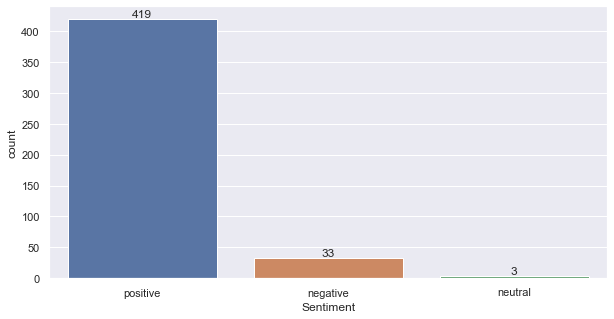

In [6]:
# bar chart of the count of Sentiments over time
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.countplot(x='Sentiment', data=df)
ax.bar_label(ax.containers[0])

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

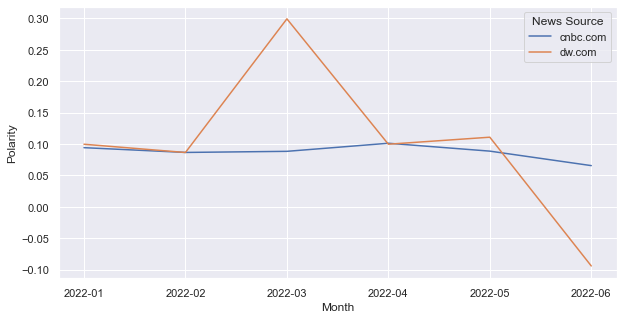

In [7]:
# line chart of the average polarity per month for each source
sns.set(rc={'figure.figsize':(10,5)})
sns.lineplot(x = 'Month', y = 'Polarity', hue='News Source', ci=None, data = df)

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

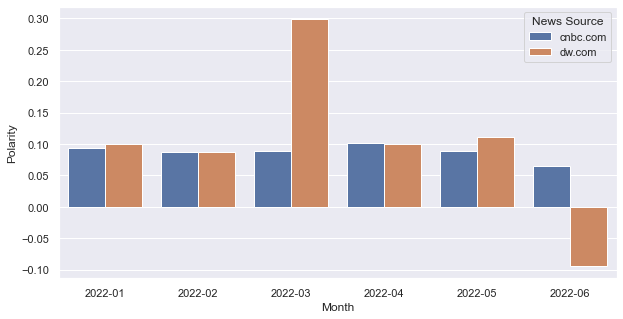

In [8]:
# bar chart of the average polarity per month for each source
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(y = 'Polarity', x = 'Month', hue='News Source', ci=None, data = df)

[Text(0, 0, '429'), Text(0, 0, '26')]

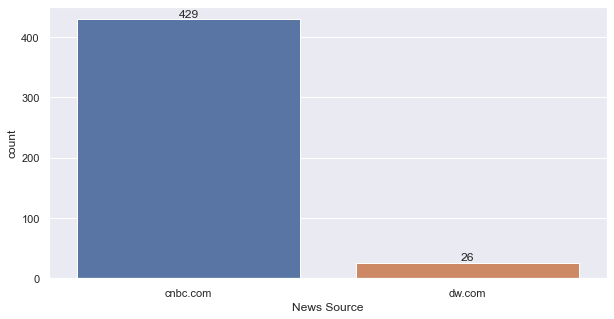

In [9]:
# bar chart of the count of news for each source
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.countplot(x='News Source', data=df)
ax.bar_label(ax.containers[0])